# Banana Distribution

In this example, we define a 2D distribution with nonlinear correlations and sample from it using the MCMC algorithms delayed rejection adaptive Metropolis (DRAM) and Hamiltonian Monte Carlo (HMC).

In [20]:
import sys
import os

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Get the parent directory
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path so we can import the mcmc_samplers module
sys.path.insert(0, parent_dir)

In [21]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
from mcmc_samplers import *
import matplotlib.pyplot as plt

## Define the target distribution

In [22]:
class Banana:

    """
    2D dimensional target distribution with a banana-shaped joint distribution.

    Attributes
        ----------
        mvn : MultivariateNormal
            Multivariate normal distribution that will be used to evaluate the log probability.
    """

    def __init__(
            self
    ):

        """
        Banana constructor.
        """
        
        mean = torch.zeros(2)
        cov = torch.tensor([[1., 0.9], [0.9, 1.]])
        self.mvn = MultivariateNormal(mean, cov)

    def log_prob(
            self,
            x : torch.Tensor
    ) -> torch.Tensor:

        """
        Evaluates the log probability of the banana distribution.

        Parameters
        ----------
        x : torch.Tensor
            Point at which to evaluate the log probability density.

        Returns
        ----------
        torch.Tensor
            The log probability density of the banana distribution at the point `x`.
        """
        
        x = torch.atleast_2d(x)
        y = torch.cat((x[:,0:1], x[:,1:2] + (x[:,0:1] + 1)**2), dim=1)
        return self.mvn.log_prob(y)

## Define initial proposal distribution and specify the number of samples to draw

In [23]:
torch.manual_seed(0) # for reproducibility
    
target = Banana()

init_sample = torch.tensor([0.,-1.])
init_cov = torch.tensor([[1., 0.9], [0.9, 1.]])

num_samples = int(1e4)

## Define the DRAM and HMC samplers

In [24]:
dram = DelayedRejectionAdaptiveMetropolis(
    target = target.log_prob,
    x0 = init_sample,
    cov = init_cov
)

In [25]:
hmc = HamiltonianMonteCarlo(
    target = target.log_prob,
    x0 = torch.nn.Parameter(init_sample), # must be a parameter so we can use PyTorch's autograd
    step_size = 0.2,
    num_steps = 3
)

## Perform sampling and visualize the results

DRAM acceptence rate: 78.04%
HMC acceptence rate: 66.79%


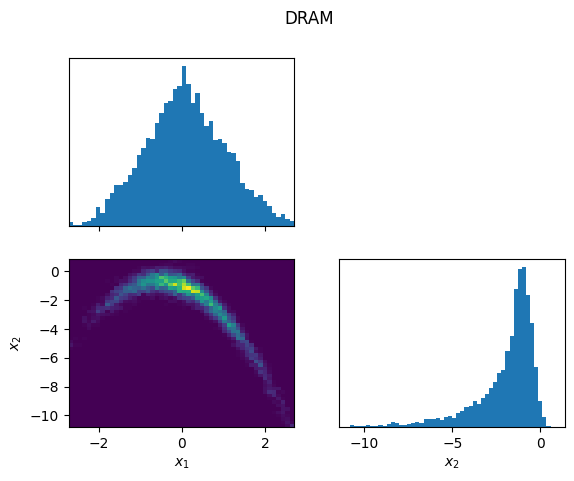

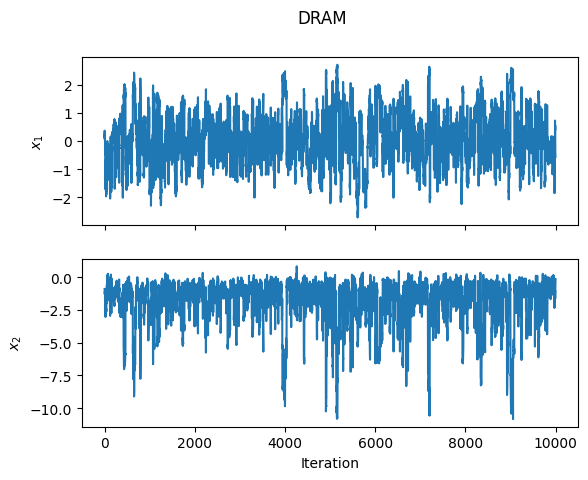

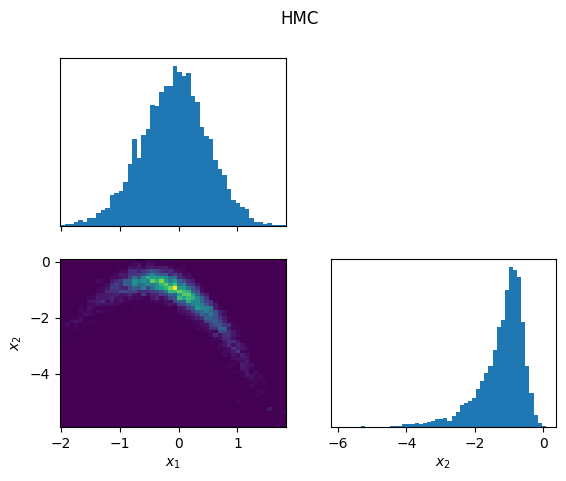

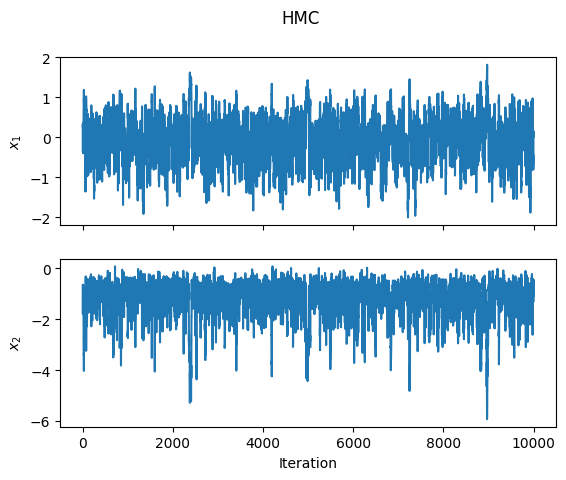

In [27]:
samplers = [dram, hmc]
titles = ['DRAM', 'HMC']
labels = ['$x_1$', '$x_2$']
visualizers = [None, None]

for ii, sampler in enumerate(samplers):
    samples, log_probs = sampler(num_samples)
    print(f'{titles[ii]} acceptence rate: {100*sampler.acceptance_ratio:.2f}%')

    visualizers[ii] = SampleVisualizer(samples)
    visualizers[ii].triangular_hist(bins=50,
                                labels=labels,
                                titles=[titles[ii]])
    visualizers[ii].chains(labels=labels,
                            titles=[titles[ii]])

plt.show()